In [137]:
import getData
import loadData
import fitData
import fitModel
import plotData
import config
import segmentation
import geometry
import workflow
import matplotlib.pyplot
import importlib
import time
import numpy
import os
import traceback
import SimpleITK
import functools
import scipy.optimize
import scipy.linalg
import sklearn.cluster
import sklearn.metrics
import sklearn.mixture
importlib.reload(loadData)
importlib.reload(fitData)
importlib.reload(fitModel)
importlib.reload(plotData)
importlib.reload(config)
importlib.reload(segmentation)
importlib.reload(geometry)
importlib.reload(workflow)
import datetime


In [2]:
def loadImageData(setup):
    
    #loadData.saveCenters(r,setup)
    #img=SimpleITK.ReadImage(os.path.join(config.getLocalDir(r,setup),config.getCenterWeight(r,setup,30,0,4)))
    #data=SimpleITK.GetArrayFromImage(img)
    #matplotlib.pyplot.imshow(data[17,:,:])
    #db,fb=getData.connectDB(setup['network'])
    fb,r=getRow(setup,True)
    getData.downloadFiles(fb,r,setup)
    return r

def getRow(setup,returnFB=False):
    qFilter=config.getFilter(setup)
    db,fb=getData.connectDB(setup['network'])
    rows=getData.getPatients(db,setup,qFilter)
    #print(rows)
    if returnFB:
        return fb,db,rows[0]
    return rows[0]
    
def saveCenters(setup, r=None):
    if not r:
        r=getRow(setup)
    nr=setup['nr']
    for ir in range(nr):
        loadData.saveCenters(r,setup,ir=ir)
        
def fitIVF(setup,r=None):
    if not r:
        r=getRow(setup)
    nr=setup['nr']
    for ir in range(nr):
        centers=loadData.loadCenters(r,setup,ir)
        loadData.saveIVF(r,setup,ir=ir,nfit=30,nbatch=60)
        
def checkFitIVF(setup,r=None,ir=0):
    if not r:
        r=getRow(setup)
    fit=loadData.readIVF(r,setup,ir=ir)
    print(fit.mu)
    print(fit.cov)
    centers=loadData.loadCenters(r,setup,ir)
    t,dt=loadData.loadTime(r,setup)
    qf=centers[fit.m]
    t1=numpy.linspace(0,numpy.max(t),300)
    fv=fitData.fIVF(t1,fit.mu)
    
    fun=functools.partial(fitData.fDiff,fitData.fIVF,t,qf,numpy.ones(t.shape))
    df=fun(fit.mu)
    
    
    
    matplotlib.pyplot.plot(t,qf)
    matplotlib.pyplot.plot(t1,fv)
    matplotlib.pyplot.plot(t,df)
    
    
def fitCompartments(setup,m,r=None, ir=0,useJac=True):
    if not r:
        r=getRow(setup)
    
    #par=fit.mu
    #n=10
    #samples=fitData.generateGauss(fit,n)
    #c1=numpy.cov(samples)
    #print(fit.cov)
    #print(c1)
    
    cPar=numpy.ones(4)
    cPar[0]=0.1/60
    cPar[1]=0.00005
    cPar[2]=0.03/60
    cPar[3]=17
    #fv=fitData.fCompartment(ivfPar,t,cPar)
    centers=loadData.loadCenters(r,setup,ir)
    t,dt=loadData.loadTime(r,setup)
    #ivf=centers[fit.m]
    qf=centers[m]
    #xs=numpy.zeros((4,n))
    #for i in range(n):
    #ivfPar=samples[:,i]
    
    fitC=fitData.fitCompartment(fit,t,qf,nfit=10,nbatch=30,useJac=useJac)
    cPar=fitC.mu
    
    print(cPar)
    try:
        print(fitC.cov)
    except NameError:
        pass
    #fun=functools.partial(fitData.fDiff,fitData.fIVF,t,ivf,numpy.ones(t.shape))
    
    fc1=functools.partial(fitData.fCompartment,fit.mu)
    fun=functools.partial(fitData.fDiff,fc1,t,qf,numpy.ones(t.shape))
    
    #result=scipy.optimize.least_squares(fun,par)
    #print(result.x)
    t1=numpy.linspace(0,numpy.max(t),300)
    fv=fitData.fCompartment(fit.mu,t1,cPar)
    #fv=fitData.fIVF(t1,par)
    df=fun(cPar)
    matplotlib.pyplot.plot(t,qf)
    matplotlib.pyplot.plot(t1,fv)
    matplotlib.pyplot.plot(t,df)
    
    
#SimpleITK.ReadImage(os.path.join(config.GetLocalDir(r,setup)

[145.73464351  10.36008617   0.84076479   6.42278732]
[[ 8.56598179e+03 -6.62455911e+00  4.62920127e+01  2.77070036e+01]
 [-6.62455911e+00  7.71532415e-02 -3.93828966e-02 -1.18914557e-01]
 [ 4.62920127e+01 -3.93828966e-02  2.70732990e-01  3.02263573e-01]
 [ 2.77070036e+01 -1.18914557e-01  3.02263573e-01  1.37849468e+00]]


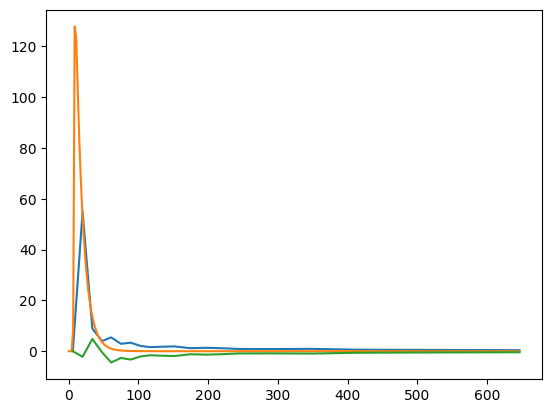

In [156]:
setup={'tempDir':'temp/dynamicSPECT',
           'ParticipantField':'PatientId',
           'visitField':'visitCode',
          'nclass':[30],
           'nr':1,
          'PatientId':'10KF',
           'visitCode':'MIR',
           'project':'dynamicSPECT/cardiacSPECT',
           'schemaName':'study',
           'queryName':'Imaging1',
           'baseDir':'processedImages',
          'network':'labkey-ukc.json'}
#r1=getRow(setup)
#loadData(setup)
#fitIVF(setup)
#fitIVF(setup,r)
checkFitIVF(setup,r)
#checkFitIVF(setup,r1)
#fitCompartments(setup,3,r,0,True)

In [139]:

def doIVF(xsetup,r,ir=0,nfit=1,nbatch=1,doDraw=False):
    nclass=xsetup['nclass'][0]
    t,dt=loadData.loadTime(r,xsetup)
    centers=loadData.loadCenters(r,xsetup,ir)
    
    return fitData.fitIVF(t,centers,nfit,nbatch)
        
def doCompartment(setup,r,ivfFit,m, useJac=False,nfit=1,nbatch=1,ir=0,useScalar=True):
    nclass=setup['nclass'][0]
    t,dt=loadData.loadTime(r,setup)
    centers=loadData.loadCenters(r,setup,ir)
    qf=centers[m]
    return fitData.fitCompartment(ivfFit,t,qf,nfit,nbatch,useJac)
   

def doCompartmentGlobal(setup,r,ivfFit,m, useJac=False,nfit=1,ir=0):
    t,dt=loadData.loadTime(r,setup)
    centers=loadData.loadCenters(r,setup,ir)
    qf=centers[m]
    return fitData.fitCompartmentGlobal(ivfFit,t,qf,nfit,useJac)
    
def doIVFGlobal(xsetup,r,ir=0,nfit=1):
    nclass=xsetup['nclass'][0]
    t,dt=loadData.loadTime(r,xsetup)
    centers=loadData.loadCenters(r,xsetup,ir)
    m=numpy.unravel_index(numpy.argmax(centers),centers.shape)[0]
    #treat it as ivf sample
    ivf=centers[m]
    return fitData.fitIVFGlobal(t,centers,nfit)
    
def plotIVF(r,setup,m,samples,threshold,file0=None,file1=None,ir=0):
    t,dt=loadData.loadTime(r,setup)
    centers=loadData.loadCenters(r,setup,ir)
    ivf=centers[m]
    
    plotData.plotIVF(t,ivf,samples,threshold,file0,file1)
              
def plotIVFRealizations(r,setup,m,samples,threshold,nplot=50,file=None,ir=0):
    t,dt=loadData.loadTime(r,setup)
    centers=loadData.loadCenters(r,setup,ir)
    ivf=centers[m]
    plotData.plotIVFRealizations(t,ivf,samples,threshold,nplot,file)
        
def plotSamples(r,setup,m,samples,file0=None,file1=None,ir=0):
    t,dt=loadData.loadTime(r,setup)
    centers=loadData.loadCenters(r,setup,ir)
    qf=centers[m]
    plotData.plotSamples(t,qf,samples,file0,file1)

def checkDF(setup,pts,qLambda):
    ir=0
    outputDF=numpy.zeros((len(pts),len(qLambda)))
    outputErr=numpy.zeros((len(pts),len(qLambda)))
    for i in range(len(pts)):
        p=pts[i]
        setup.update(p)
        fb,db,r=getRow(setup,True)                  
        for k in range(len(qLambda)):
            qLam=qLambda[k]
            setup['qLambda']=qLam
            #get samples
            m,samples=loadData.readIVF(r,setup,qLambda=qLam)
            t,dt=loadData.loadTime(r,setup)
            centers=loadData.loadCenters(r,setup,ir=ir)
            ivf=centers[m]
            w=numpy.ones(t.shape)
            fun=functools.partial(fitModel.fDiff,fitModel.fIVF,t,ivf,w)
            chi2=numpy.zeros(samples.shape[1])
            for j in range(samples.shape[1]):
                cPar=samples[1:,j]
                df=fun(cPar)
                chi2[j]=(df*df).sum()
            print('[{} {} {}]: {:.2f} / {:.2f} ({:.2f})'.format(p['PatientId'],p['visitCode'],qLam,samples[0,j],numpy.mean(chi2),numpy.std(chi2)))
            outputDF[i,k]=numpy.mean(chi2)
            outputErr[i,k]=numpy.std(chi2)/numpy.sqrt(samples.shape[1])
            #break
        #break
    return outputDF,outputErr

def generateDF(setup,pts,qLambda):
    for p in pts:
        setup.update(p)
        fb,db,r=getRow(setup,True)                  
        for j in range(len(qLambda)):
            qLam=qLambda[j]
            setup['qLambda']=qLam
            #print(r['visitCode'])
            if j==0:
                seg=workflow.workflow(r,setup,'setCenters',fb=fb,db=db)
            seg=workflow.workflow(r,setup,'fitIVF',fb=fb,db=db)
            seg=workflow.workflow(r,setup,'plotIVF',fb=fb,db=db)
            #seg=workflow(r,setup,'fitCompartment',fb=fb,db=db)
            #seg=workflow(r,setup,'plotCompartment',fb=fb,db=db)
            
def uploadFiles(setup,pts,qLambda):
    for p in pts:
        setup.update(p)
        fb,db,r=getRow(setup,True)                  
        for j in range(len(qLambda)):
            qLam=qLambda[j]
            setup['qLambda']=qLam
            if j==0:
                workflow.uploadCreatedFiles('setCenters',fb,r,setup)
            workflow.uploadCreatedFiles('fitIVF',fb,r,setup)
            workflow.uploadCreatedFiles('plotIVF',fb,r,setup)
            categories=['fits','diff','generatedIVF','centerIVFSPECT','centerIVFCT']
            workflow.updateDatabase(r,setup,'plotIVF',db=db,fb=fb,categories=categories)
            
def 
            

setup={'tempDir':'temp/dynamicSPECT',
           'ParticipantField':'PatientId',
           'visitField':'visitCode',
          'nclass':[30],
           'nr':1,
          'PatientId':'MB1965',
           'visitCode':'MIR',
           'project':'dynamicSPECT/cardiacSPECT',
           'schemaName':'study',
           'queryName':'Imaging1',
           'baseDir':'processedImages',
          'network':'labkey-ukc.json',
           'segmentationMode':'NRRD',
           'targetUser':'1007',
           'segmentationQueryName':'Segmentations',
           'qLambda':0.05
          }                   
pts=[{'PatientId':'MB1965','visitCode':'MIR'},
     {'PatientId':'MB1965','visitCode':'MIR1'},
     {'PatientId':'MB1965','visitCode':'MIR2'},
     {'PatientId':'MM','visitCode':'MIR1'},
     {'PatientId':'TT1998','visitCode':'MIR'},
     {'PatientId':'VV1984','visitCode':'MIR'},
     {'PatientId':'VV1984','visitCode':'MIR1'}]
qLambda=[0,0.01,0.05,0.1,1]

#generateDF(setup,pts,qLambda)
uploadFiles(setup,pts,qLambda)
#outputDF,outputErr=checkDF(setup,pts,qLambda)
#fb,db,r=getRow(setup,True)       
#workflow.workflow(r,setup,'plotIVF',fb=fb,db=db)

loadLibrary
remoteSourcesURL https://git0.fmf.uni-lj.si/studen/nixSuite/raw/master/remoteResources/resources.json
{'labkeyInterface': {'url': 'https://git0.fmf.uni-lj.si/studen/labkeyInterface/archive/master.zip', 'branch': 'master', 'modules': []}, 'irAEMM': {'url': 'https://git0.fmf.uni-lj.si/studen/iraemm/archive/master.zip', 'branch': 'master', 'modules': ['iraemmBrowser']}, 'SlicerLabkeyExtension': {'url': 'https://git0.fmf.uni-lj.si/studen/SlicerLabkeyExtension/archive/SlicerExtensionIndex.zip', 'branch': 'SlicerExtensionIndex', 'modules': ['labkeyBrowser']}, 'limfomiPET': {'url': 'https://git0.fmf.uni-lj.si/studen/limfomiPET/archive/master.zip', 'branch': 'master', 'modules': ['imageBrowser', 'segmentationBrowser']}, 'parseConfig': {'url': 'https://git0.fmf.uni-lj.si/studen/parseConfig/archive/master.zip', 'branch': 'master', 'modules': []}, 'orthancInterface': {'url': 'https://git0.fmf.uni-lj.si/studen/orthancInterface/archive/master.zip', 'branch': 'master', 'modules': []}, 'd

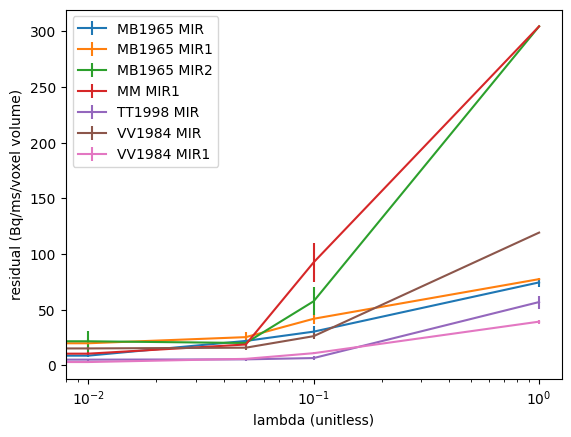

In [123]:
#matplotlib.pyplot.plot(qLambda,outputDF.transpose())
for i in range(len(pts)):
    p=pts[i]
    matplotlib.pyplot.errorbar(qLambda,outputDF[i,:],yerr=outputErr[i,:],label='{} {}'.format(p['PatientId'],p['visitCode']))
matplotlib.pyplot.xscale('log')
matplotlib.pyplot.xlabel('lambda (unitless)')
matplotlib.pyplot.ylabel('residual (Bq/ms/voxel volume)')

matplotlib.pyplot.legend()
matplotlib.pyplot.savefig('LambdaOptimization.png')


(64, 64, 64)
29


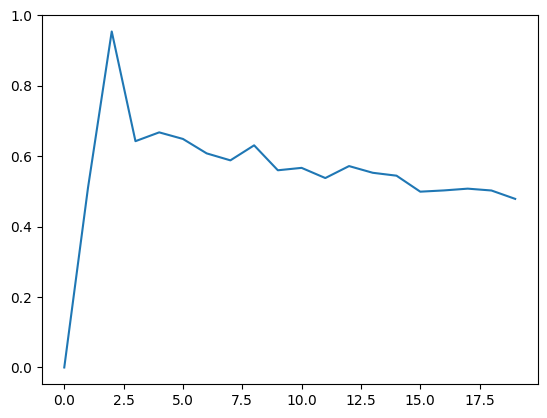

In [80]:
code=config.getCode(r,setup)
spect,gSPECT=loadData.loadData(r,setup,returnGeometry=True)
centers=loadData.loadCenters(r,setup)
ct,gCT=loadData.loadCT(r,setup,returnGeometry=True)
f=getData.getLocalPath(r,setup,config.getPattern('centerNRRD',code=code,nclass=30,ir=0,qaName='SPECT')) 
xd=SimpleITK.ReadImage(f)
u=SimpleITK.GetArrayFromImage(xd)
print(u.shape)
print(numpy.max(u))
numpy.sum(u==1)
matplotlib.pyplot.plot(centers[1])


In [57]:
numpy.sum(u1==7)

53073